In [111]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

# The final function

In [ ]:
def load_vcl(file):
    with open(file, "rb") as f:
        byte_stream = bytearray(f.read())

    column_names_bytes = byte_stream[0x400+0x1400:0x400+0x1400+0x1700]
    column_names = list()

    for i in range(184):
        b = column_names_bytes[i*32:(i+1)*32]
        if b[0] != 0:
            s = b.decode().rstrip("\x00")
            column_names.append(s)

    # This is where data starts
    data_bytes = byte_stream[0x3000:]
    # Truncate it to a full row
    bytes_full_records = int(len(data_bytes)/8/len(column_names))*8*len(column_names)
    data_bytes = data_bytes[0:bytes_full_records]
    # Now convert from bytes to double floating point and reshape
    data = np.frombuffer(data_bytes, 'd')
    data = np.reshape(data, [len(data)//len(column_names),len(column_names)])
    return pd.DataFrame(data, columns=column_names)

# The debugging process

In [4]:
base_path = "/home/jovyan/cryo_logs/triton_logs/LogFiles/58487 Steele/"
vcl_files = glob.glob(base_path + "*.vcl")

In [6]:
file = vcl_files[-1]
file

'/home/jovyan/cryo_logs/triton_logs/LogFiles/58487 Steele/log 200909 121001.vcl'

In [13]:
with open(file, "rb") as f:
    byte_stream = bytearray(f.read())

In [14]:
type(byte_stream)

bytearray

In [17]:
len(byte_stream[0:0x3000])

12288

In [22]:
header = byte_stream[0:0x400]
print(header.decode())

VeriCold data logfile.
(c) 2010 Oxford Instruments plc.
To read this file you will need a log file reader from Oxford Instruments.

Log File Version: no version number assigned

Original filename: C:/Oxford Instruments/logfiles/58487 Steele/log 200909 121001.vcl
Creation date: 2020-09-09T12:10:01
Last write access: 2020-09-09T12:10:01
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [32]:
comments = byte_stream[0x0400:0x0400+0x1400]
print(comments.decode())

This is the standard comments block                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [116]:
column_names_bytes = byte_stream[0x400+0x1400:0x400+0x1400+0x1700]
column_names = list()

for i in range(184):
    #print(column_names[i*32:(i+1)*32])
    b = column_names_bytes[i*32:(i+1)*32]
    if b[0] != 0:
        s = b.decode().rstrip("\x00")
        print(i, s)
        column_names.append(s)
    #print("%d %d _%s_" % (len(s), s))

0 LineSize(bytes)
1 LineNumber
2 Time(secs)
3 P2 Condense (Bar)
4 P1 Tank (Bar)
5 P5 ForepumpBack (Bar)
6 P3 Still (mBar)
7 P4 TurboBack (mBar)
8 Dewar (mBar)
9 Input Water Temp
10 Output Water Temp
11 Helium Temp
12 Oil Temp
13 Motor Current
14 Low Pressure
15 High Pressure
16 PT2 Head t(s)
17 PT2 Head T(K)
18 PT2 Head R(Ohm)
19 PT2 Plate t(s)
20 PT2 Plate T(K)
21 PT2 Plate R(Ohm)
22 Still Plate t(s)
23 Still Plate T(K)
24 Still Plate R(Ohm)
25 Cold Plate t(s)
26 Cold Plate T(K)
27 Cold Plate R(Ohm)
28 MC Plate Cernox t(s)
29 MC Plate Cernox T(K)
30 MC Plate Cernox R(Ohm)
31 PT1 Head t(s)
32 PT1 Head T(K)
33 PT1 Head R(Ohm)
34 PT1 Plate t(s)
35 PT1 Plate T(K)
36 PT1 Plate R(Ohm)
37 MC Plate t(s)
38 MC Plate T(K)
39 MC Plate R(Ohm)
40 chan[8] t(s)
41 chan[8] T(K)
42 chan[8] R(Ohm)
43 chan[9] t(s)
44 chan[9] T(K)
45 chan[9] R(Ohm)
46 chan[10] t(s)
47 chan[10] T(K)
48 chan[10] R(Ohm)
49 chan[11] t(s)
50 chan[11] T(K)
51 chan[11] R(Ohm)
52 chan[12] t(s)
53 chan[12] T(K)
54 chan[12] R(Ohm)

In [117]:
column_names[0]

'LineSize(bytes)'

In [118]:
data_bytes = byte_stream[0x3000:]

How many columns? 

> The LineSize(bytes) value (converted to an integer count) should be equal the count of non-empty Column Names times 8.

I should be able to figure this out from the number of columns with non-empty column names, and also cross check with the (identical) entry of LineSize in each of the rows. 

In [119]:
len(column_names)*8

504

In [120]:
import struct

In [121]:
struct.unpack('d', data_bytes[0:8])

(504.0,)

OK, this works!

Now, just to do this vectorised! :)

In [122]:
# Slice out data, truncate at last full record
data_bytes = np.frombuffer(byte_stream[0x3000:], dtype='d')
bytes_full_records = int(len(data)/8/len(column_names))*8*len(column_names)
data_bytes = data[0:bytes_full_records]

# Reshape into appropriate array
data = np.frombuffer(data_bytes, 'd')
data = np.reshape(data, [len(data)//len(column_names),len(column_names)])

# Make a dataframe
df = pd.DataFrame(data, columns=column_names)

In [123]:
df.keys()

Index(['LineSize(bytes)', 'LineNumber', 'Time(secs)', 'P2 Condense (Bar)',
       'P1 Tank (Bar)', 'P5 ForepumpBack (Bar)', 'P3 Still (mBar)',
       'P4 TurboBack (mBar)', 'Dewar (mBar)', 'Input Water Temp',
       'Output Water Temp', 'Helium Temp', 'Oil Temp', 'Motor Current',
       'Low Pressure', 'High Pressure', 'PT2 Head t(s)', 'PT2 Head T(K)',
       'PT2 Head R(Ohm)', 'PT2 Plate t(s)', 'PT2 Plate T(K)',
       'PT2 Plate R(Ohm)', 'Still Plate t(s)', 'Still Plate T(K)',
       'Still Plate R(Ohm)', 'Cold Plate t(s)', 'Cold Plate T(K)',
       'Cold Plate R(Ohm)', 'MC Plate Cernox t(s)', 'MC Plate Cernox T(K)',
       'MC Plate Cernox R(Ohm)', 'PT1 Head t(s)', 'PT1 Head T(K)',
       'PT1 Head R(Ohm)', 'PT1 Plate t(s)', 'PT1 Plate T(K)',
       'PT1 Plate R(Ohm)', 'MC Plate t(s)', 'MC Plate T(K)', 'MC Plate R(Ohm)',
       'chan[8] t(s)', 'chan[8] T(K)', 'chan[8] R(Ohm)', 'chan[9] t(s)',
       'chan[9] T(K)', 'chan[9] R(Ohm)', 'chan[10] t(s)', 'chan[10] T(K)',
       'chan[10]

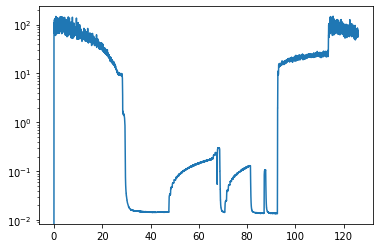

In [131]:
hours = (df['Time(secs)']-df["Time(secs)"][0])/3600
plt.plot(hours, df['MC Plate T(K)'])
plt.yscale('log')

OK, we're good to go!